# Разработка модели кластеризации данных о вакансиях из открытых источников

### Используемые библиотеки

In [1]:
!pip install pymorphy2

In [3]:
!pip install hdbscan

In [88]:
import requests
import csv
import random
import time
import logging

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MultiLabelBinarizer
import nltk
from nltk.corpus import stopwords
from collections import Counter
import pymorphy2
import string
from gensim.models import Word2Vec
import re

import ast
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings('ignore')

### Сбор датасета

***установка токена API HeadHunter***

In [ ]:
hh_api_token = '***'

+ City: Город, где размещена вакансия (например, "Москва" или "Санкт-Петербург"). +
+ Company: Название компании, разместившей вакансию. +
+ Industry: Отрасль компании (например, "IT", "Финансы" или "Unknown" при отсутствии данных). -
+ Title: Полное название вакансии, включая указание города (например, "Data Scientist (Москва)"). +
+ Keywords: Основные требования или ключевые слова из описания вакансии (если есть). +
+ Skills: Список ключевых навыков, требуемых для вакансии (например, "Python, Machine Learning"). +
+ Experience: Уровень опыта, необходимый для вакансии (например, "От 1 до 3 лет"). +
+ Salary: Указанная зарплата или "з/п не указана", если информация отсутствует. +
+ URL: Ссылка на страницу вакансии на сайте HeadHunter. -\
Эти столбцы покрывают основную информацию о вакансиях, что делает датасет полезным для анализа и дальнейшего использования.

In [ ]:
# Настройка логирования
logging.basicConfig(level=logging.INFO, format='%(levelname)s - %(message)s')

In [ ]:
# Функция для получения вакансий
def get_vacancies(city, vacancy, page):
    url = 'https://api.hh.ru/vacancies'
    params = {
        'text': f"{vacancy} {city}",
        'location': city,
        'specialization': 1,
        'per_page': 100,
        'page': page
    }
    headers = {
        'Authorization': f'Bearer {hh_api_token}'
    }

    response = requests.get(url, params=params, headers=headers)
    response.raise_for_status()
    return response.json()

In [ ]:
# Функция для получения навыков вакансии
def get_vacancy_skills(vacancy_id):
    url = f'https://api.hh.ru/vacancies/{vacancy_id}'
    headers = {
        'Authorization': f'Bearer {hh_api_token}'
    }

    response = requests.get(url, headers=headers)
    response.raise_for_status()
    data = response.json()

    skills = [skill['name'] for skill in data.get('key_skills', [])]
    return ', '.join(skills)

In [ ]:
# Основная функция для парсинга вакансий и сохранения в CSV
def parse_vacancies_to_csv(output_file):
    cities = {
        'Москва': 1,
        'Санкт-Петербург': 2
    }

    vacancies = [
             'Офис-менеджер', 'Кладовщик', 'Системный администратор', 'Торговый представитель', 'Юрист', 'Инженер ПТО',
             'Геодезист', 'Дворник', 'Руководитель отдела продаж', 'Грузчик', 'Медицинский представитель',
             'Юрисконсульт', 'Мастер ногтевого сервиса', 'Охранник', 'Хостес', 'Ветеринарный врач', 'Товаровед',
             'Специалист по охране труда', 'Бухгалтер', 'Фармацевт-провизор', 'Разнорабочий', 'Главный инженер',
             'Администратор', 'Мерчендайзер', 'Кассир', 'Экономист', 'Менеджер по персоналу', 'Системный аналитик',
             'Официант', 'Диспетчер', 'Бизнес-аналитик', 'Финансовый аналитик', 'Аналитик данных'
                ]

    with open(output_file, mode='w', encoding='utf-8', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['City', 'Company', 'Industry', 'Title', 'Keywords', 'Skills', 'Experience', 'Salary', 'URL'])

        for city, city_id in cities.items():
            for vacancy in vacancies:
                page = 0
                while True:
                    try:
                        data = get_vacancies(city_id, vacancy, page)

                        if not data.get('items'):
                            break

                        for item in data['items']:
                            if vacancy.lower() not in item['name'].lower():
                                continue

                            title = f"{item['name']} ({city})"
                            keywords = item['snippet'].get('requirement', '')
                            skills = get_vacancy_skills(item['id'])
                            company = item['employer']['name']
                            industry = get_industry(item['employer'].get('id')) # ---
                            experience = item['experience'].get('name', '')
                            salary = item['salary']
                            salary = "з/п не указана" if salary is None else salary.get('from', '')
                            url = item['alternate_url']

                            writer.writerow([city, company, industry, title, keywords, skills, experience, salary, url])

                        if page >= data['pages'] - 1:
                            break

                        page += 1
                        time.sleep(random.uniform(3, 6))  # Задержка между запросами

                    except requests.HTTPError as e:
                        logging.error(f"Ошибка при обработке города {city}: {e}")
                        break

    logging.info(f"Парсинг завершен. Данные сохранены в файл {output_file}.")

In [ ]:
parse_vacancies_to_csv('vacancies.csv')

INFO - Парсинг завершен. Данные сохранены в файл vacancies.csv.


In [ ]:
vacancies = pd.read_csv('vacancies.csv', index=False)
vacancies = vacancies.drop_duplicates(subset='URL', keep='first')
vacancies = vacancies.drop('URL', axis=1)
vacancies.to_csv('vacancies.csv', index=False)

In [32]:
vacancies = pd.read_csv('vacancies.csv')
vacancies.head()

,City,Company,Title,Keywords,Skills,Experience,Salary
0,Москва,ГК Садовое кольцо,Инженер ПТО,Обязанности: Расчет объемов и подгото...,"AutoCAD,Пользователь ПК,Работа с большим объем...",От 3 до 6 лет,от 160000 RUR
1,Москва,ПРОФ-БУХГАЛТЕР ДВ,Бухгалтер,Обязанности: Работа в аутсорсинговой ...,NaN,От 3 до 6 лет,от 40000 до 70000 RUR
2,Москва,Содби,Офис-менеджер,Менеджер по продажам ГК Содби с 2008 г. на ры...,"Заключение договоров,Пользователь ПК,Деловое о...",От 1 года до 3 лет,от 40000 до 60000 RUR
3,Москва,ТОМАТО,Хостес,Работа в ТОМАТО – отличный вариант. Есл...,"Грамотная речь,Опрятный внешний вид,умение про...",Нет опыта,от 30000 RUR
4,Москва,МультиКарта,Системный администратор,МультиКарта представляет широкий спектр вы...,"AD,ОС Windows,MS SQL Server,Microsoft Exchange...",От 1 года до 3 лет,з/п не указана


## Предобработка данных

Кластерный анализ будем проводить по ***4 факторам***: ключевые слова (описание), навыки, требуемый опыт работы, зароботная плата. Для этого предобработаем данные.

***Опыт работы***

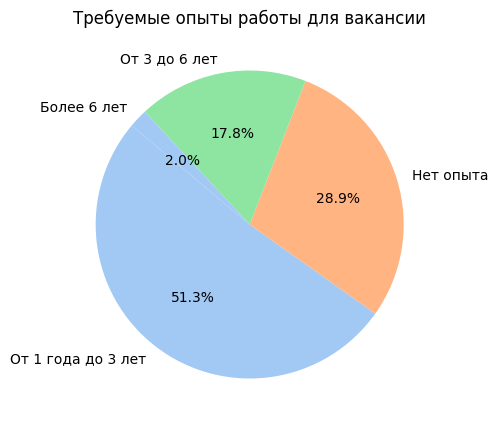

In [33]:
colors = sns.color_palette('pastel')[0:3]

plt.figure(figsize=(5, 5))
plt.pie(list(vacancies['Experience'].value_counts()), labels=list(vacancies['Experience'].value_counts().index), colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Требуемые опыты работы для вакансии')

plt.show()

In [34]:
vacancies['Experience'].isna().sum() # проверка на наличие пропусков в столбце

0

Для кодирования опыта работы будем использовать порядковое кодирование, так как категории имеют естественный порядок.

In [35]:
experience_mapping = {
    'Нет опыта': 0,
    'От 1 года до 3 лет': 1,
    'От 3 до 6 лет': 2,
    'Более 6 лет': 3
}

vacancies['Experience_coded'] = vacancies['Experience'].map(experience_mapping)
vacancies['Experience_coded'].value_counts()

,count
Experience_coded,
1,13884
0,7828
2,4827
3,532


***Заработная плата***

In [36]:
vacancies['Salary'].str[:2].value_counts()

,count
Salary,
от,19114
з/,3560


З/п всех вакансий начинается со слова "от" кроме тех, у которых з/п не указана. Неуказанные зарплаты будут заменяться на медиану зароботных плат в разрезе вакансии.

З/п вакансий, где она указана, отбирается по минимальному значению.

In [37]:
vacancies['Salary_coded'] = pd.to_numeric(vacancies['Salary'].replace('з/п не указана', np.nan).str.split().str[1])

In [38]:
vacancies['Salary_coded'] = vacancies.groupby('Title')['Salary_coded'].transform(lambda x: x.fillna(x.median()))

In [39]:
vacancies.head()

,City,Company,Title,Keywords,Skills,Experience,Salary,Experience_coded,Salary_coded
0,Москва,ГК Садовое кольцо,Инженер ПТО,Обязанности: Расчет объемов и подгото...,"AutoCAD,Пользователь ПК,Работа с большим объем...",От 3 до 6 лет,от 160000 RUR,2,160000.0
1,Москва,ПРОФ-БУХГАЛТЕР ДВ,Бухгалтер,Обязанности: Работа в аутсорсинговой ...,NaN,От 3 до 6 лет,от 40000 до 70000 RUR,2,40000.0
2,Москва,Содби,Офис-менеджер,Менеджер по продажам ГК Содби с 2008 г. на ры...,"Заключение договоров,Пользователь ПК,Деловое о...",От 1 года до 3 лет,от 40000 до 60000 RUR,1,40000.0
3,Москва,ТОМАТО,Хостес,Работа в ТОМАТО – отличный вариант. Есл...,"Грамотная речь,Опрятный внешний вид,умение про...",Нет опыта,от 30000 RUR,0,30000.0
4,Москва,МультиКарта,Системный администратор,МультиКарта представляет широкий спектр вы...,"AD,ОС Windows,MS SQL Server,Microsoft Exchange...",От 1 года до 3 лет,з/п не указана,1,55000.0


***Навыки***

Столбец содержит большое количетсво пропусков, поэтому было решено заменить пропуски на ''. Непустые данные очищаются для того, чтобы использовать их в модели Word2Vec с веткорами размера 100.

In [40]:
vacancies['Skills'] = vacancies['Skills'].fillna('')

In [41]:
def clean_and_split_skills(skills):
    if pd.isna(skills):
        return []
    skill_list = skills.split(',')
    return [skill.strip().translate(str.maketrans('', '', string.punctuation)) for skill in skill_list]

vacancies['Skills_Tokenized'] = vacancies['Skills'].apply(clean_and_split_skills)

In [42]:
sentences = vacancies['Skills_Tokenized'].tolist()
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4, sg=1)

In [43]:
def get_skills_vector(skills, model):
    vectors = []
    for skill in skills:
        if skill in model.wv:
            vectors.append(model.wv[skill])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [44]:
vacancies['Skills_Vector'] = vacancies['Skills_Tokenized'].apply(lambda x: get_skills_vector(x, model))

In [45]:
vacancies.head()

,City,Company,Title,Keywords,Skills,Experience,Salary,Experience_coded,Salary_coded,Skills_Tokenized,Skills_Vector
0,Москва,ГК Садовое кольцо,Инженер ПТО,Обязанности: Расчет объемов и подгото...,"AutoCAD,Пользователь ПК,Работа с большим объем...",От 3 до 6 лет,от 160000 RUR,2,160000.0,"[AutoCAD, Пользователь ПК, Работа с большим об...","[-0.36165166, 0.40902078, -0.25152245, 0.13907..."
1,Москва,ПРОФ-БУХГАЛТЕР ДВ,Бухгалтер,Обязанности: Работа в аутсорсинговой ...,,От 3 до 6 лет,от 40000 до 70000 RUR,2,40000.0,[],"[-0.005425917, 0.019153, -0.009284015, 0.02818..."
2,Москва,Содби,Офис-менеджер,Менеджер по продажам ГК Содби с 2008 г. на ры...,"Заключение договоров,Пользователь ПК,Деловое о...",От 1 года до 3 лет,от 40000 до 60000 RUR,1,40000.0,"[Заключение договоров, Пользователь ПК, Делово...","[-0.3945629, 0.31998116, -0.17819281, -0.10066..."
3,Москва,ТОМАТО,Хостес,Работа в ТОМАТО – отличный вариант. Есл...,"Грамотная речь,Опрятный внешний вид,умение про...",Нет опыта,от 30000 RUR,0,30000.0,"[Грамотная речь, Опрятный внешний вид, умение ...","[-0.4592197, 0.12869781, 0.04161279, -0.362584..."
4,Москва,МультиКарта,Системный администратор,МультиКарта представляет широкий спектр вы...,"AD,ОС Windows,MS SQL Server,Microsoft Exchange...",От 1 года до 3 лет,з/п не указана,1,55000.0,"[AD, ОС Windows, MS SQL Server, Microsoft Exch...","[-0.08826005, 0.092564754, -0.031143064, 0.080..."


***Описания вакансий***

Сначала описания были проверены на отсутствие пропущенных значений: не выявлено. Затем текстовые описания были преобразованы в структурированные представления. Каждое описание было обработано для извлечения ключевых слов с помощью лемматизации, а также были удалены стоп-слова. Для дальнейшего уточнения данных в качестве репрезентативных ключевых слов были выбраны только 10 наиболее часто встречающихся слов в каждом описании. Затем обработанные ключевые слова были преобразованы в числовые векторы с помощью модели Word2Vec сразмером векторов 50.


In [46]:
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
vacancies['Keywords'].isna().sum()

0

In [48]:
def lemmatize_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    lemmas = []
    for word in text.split():
        if word not in stop_words:
            parsed_word = morph.parse(word)[0]
            lemma = parsed_word.normal_form
            lemmas.append(lemma)
    return lemmas

morph = pymorphy2.MorphAnalyzer()
vacancies['Keywords'] = vacancies['Keywords'].apply(lemmatize_text)

In [49]:
vacancies['Keywords'] = vacancies['Keywords'].apply(lambda x: [word for word, freq in Counter(x).most_common(10)])
vacancies.head()

,City,Company,Title,Keywords,Skills,Experience,Salary,Experience_coded,Salary_coded,Skills_Tokenized,Skills_Vector
0,Москва,ГК Садовое кольцо,Инженер ПТО,"[документация, рабочий, работа, подготовка, ко...","AutoCAD,Пользователь ПК,Работа с большим объем...",От 3 до 6 лет,от 160000 RUR,2,160000.0,"[AutoCAD, Пользователь ПК, Работа с большим об...","[-0.36165166, 0.40902078, -0.25152245, 0.13907..."
1,Москва,ПРОФ-БУХГАЛТЕР ДВ,Бухгалтер,"[работа, бухгалтерский, учёт, обязанность, аут...",,От 3 до 6 лет,от 40000 до 70000 RUR,2,40000.0,[],"[-0.005425917, 0.019153, -0.009284015, 0.02818..."
2,Москва,Содби,Офис-менеджер,"[продажа, работа, менеджер, компания, год, 000...","Заключение договоров,Пользователь ПК,Деловое о...",От 1 года до 3 лет,от 40000 до 60000 RUR,1,40000.0,"[Заключение договоров, Пользователь ПК, Делово...","[-0.3945629, 0.31998116, -0.17819281, -0.10066..."
3,Москва,ТОМАТО,Хостес,"[работа, оформление, томато, отличный, вариант...","Грамотная речь,Опрятный внешний вид,умение про...",Нет опыта,от 30000 RUR,0,30000.0,"[Грамотная речь, Опрятный внешний вид, умение ...","[-0.4592197, 0.12869781, 0.04161279, -0.362584..."
4,Москва,МультиКарта,Системный администратор,"[работа, знание, уверенный, опыт, наш, мы, win...","AD,ОС Windows,MS SQL Server,Microsoft Exchange...",От 1 года до 3 лет,з/п не указана,1,55000.0,"[AD, ОС Windows, MS SQL Server, Microsoft Exch...","[-0.08826005, 0.092564754, -0.031143064, 0.080..."


In [50]:
sentences = vacancies['Keywords'].tolist()
model = Word2Vec(sentences, vector_size=50, window=5, min_count=1, workers=4, sg=1)

In [51]:
def get_keywords_vector(keywords, model):
    vectors = []
    for keyword in keywords:
        if keyword in model.wv:
            vectors.append(model.wv[keyword])
    return np.mean(vectors, axis=0)

In [52]:
vacancies['Keywords_Vector'] = vacancies['Keywords'].apply(lambda x: get_skills_vector(x, model))

In [53]:
vacancies.head()

,City,Company,Title,Keywords,Skills,Experience,Salary,Experience_coded,Salary_coded,Skills_Tokenized,Skills_Vector,Keywords_Vector
0,Москва,ГК Садовое кольцо,Инженер ПТО,"[документация, рабочий, работа, подготовка, ко...","AutoCAD,Пользователь ПК,Работа с большим объем...",От 3 до 6 лет,от 160000 RUR,2,160000.0,"[AutoCAD, Пользователь ПК, Работа с большим об...","[-0.36165166, 0.40902078, -0.25152245, 0.13907...","[0.16657344, -0.05912312, -0.10726492, -0.0338..."
1,Москва,ПРОФ-БУХГАЛТЕР ДВ,Бухгалтер,"[работа, бухгалтерский, учёт, обязанность, аут...",,От 3 до 6 лет,от 40000 до 70000 RUR,2,40000.0,[],"[-0.005425917, 0.019153, -0.009284015, 0.02818...","[0.20532, -0.29260483, 0.05939267, 0.052702796..."
2,Москва,Содби,Офис-менеджер,"[продажа, работа, менеджер, компания, год, 000...","Заключение договоров,Пользователь ПК,Деловое о...",От 1 года до 3 лет,от 40000 до 60000 RUR,1,40000.0,"[Заключение договоров, Пользователь ПК, Делово...","[-0.3945629, 0.31998116, -0.17819281, -0.10066...","[0.29901165, -0.1654431, 0.049039327, 0.040970..."
3,Москва,ТОМАТО,Хостес,"[работа, оформление, томато, отличный, вариант...","Грамотная речь,Опрятный внешний вид,умение про...",Нет опыта,от 30000 RUR,0,30000.0,"[Грамотная речь, Опрятный внешний вид, умение ...","[-0.4592197, 0.12869781, 0.04161279, -0.362584...","[0.26148042, -0.06519204, -0.042955846, -0.109..."
4,Москва,МультиКарта,Системный администратор,"[работа, знание, уверенный, опыт, наш, мы, win...","AD,ОС Windows,MS SQL Server,Microsoft Exchange...",От 1 года до 3 лет,з/п не указана,1,55000.0,"[AD, ОС Windows, MS SQL Server, Microsoft Exch...","[-0.08826005, 0.092564754, -0.031143064, 0.080...","[0.33146614, 0.10114269, 0.09346803, -0.028802..."


In [54]:
vacancies.to_csv('vacancies_for_clustering.csv', index=False)

## Реализация методов кластеризации

Для реализации моделей было отобрано 4 фактора (два из которых являются векторами).

In [56]:
skills_vector_df = pd.DataFrame(vacancies['Skills_Vector'].tolist(), index=vacancies.index)
skills_vector_df.columns = [f'Skill_{i}' for i in range(skills_vector_df.shape[1])]

keywords_vector_df = pd.DataFrame(vacancies['Keywords_Vector'].tolist(), index=vacancies.index)
keywords_vector_df.columns = [f'Keyword_{i}' for i in range(keywords_vector_df.shape[1])]

vacancies = pd.concat([vacancies, skills_vector_df, keywords_vector_df], axis=1)

features = vacancies[['Salary_coded', 'Experience_coded'] + skills_vector_df.columns.tolist() + keywords_vector_df.columns.tolist()]

***Kmeans***

Подбор количества кластеров производился методом локтя. ПОиск "локтя" производился с помощью графика: количество кластеров - это точка, где инерция спада перестает уменьшатьсяс увеличением k. Такой точкой является 4.

In [69]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [70]:
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

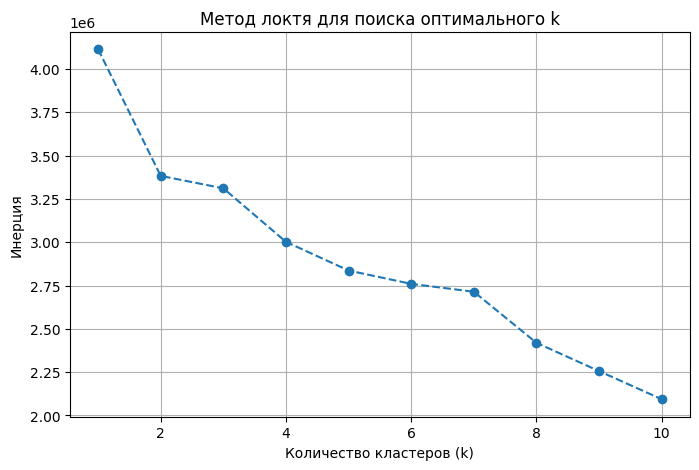

In [71]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Инерция')
plt.title('Метод локтя для поиска оптимального k')
plt.grid()
plt.show()

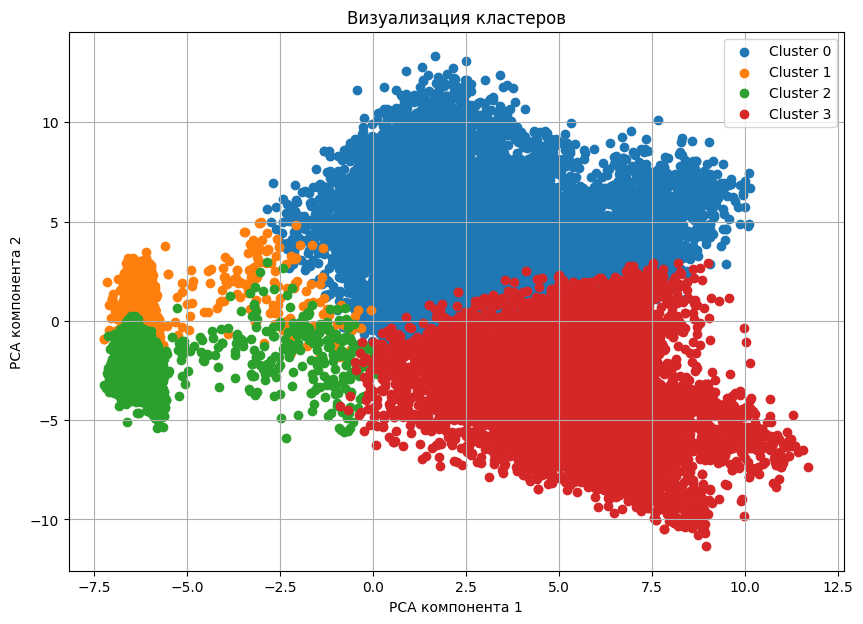

In [72]:
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_scaled)

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(features_scaled)

clusters_kmeans = kmeans.predict(features_scaled)

plt.figure(figsize=(10, 7))
for cluster in range(4):
    cluster_points = features_2d[clusters_kmeans == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')


plt.title('Визуализация кластеров')
plt.xlabel('PCA компонента 1')
plt.ylabel('PCA компонента 2')
plt.legend()
plt.grid()
plt.show()

На графике видно, что модель хорошо справилась с кластеризацией данных: видны четкие границы между кластерами.

***HDBSCAN***

HDBSCAN является улучшением DBSCAN. Модель автоматически определяет количество кластеров, а также лучше работает с шумовыми точками, что характерно для наших данных. На основе модели Kmeans можно выделить, что данные могут иметь разные размеры кластеров, с чем как раз и справляется HDBSCAN.

In [102]:
HDBSCAN = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=7, metric='manhattan')
clusters_HDBSCAN = HDBSCAN.fit_predict(features_scaled)
print("Количество кластеров (включая шум):", len(set(clusters_HDBSCAN)))
print("Шумовые точки:", sum(clusters_HDBSCAN == -1))

Количество кластеров (включая шум): 77
Шумовые точки: 19528


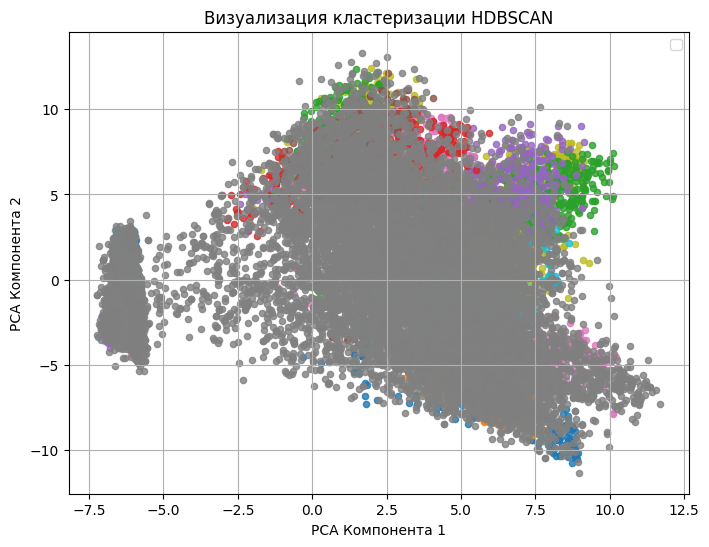

In [103]:
plt.figure(figsize=(8, 6))
for cluster in set(clusters_HDBSCAN):
    if cluster == -1:
        color = 'grey'  # Шум
        label = 'Noise'
    else:
        color = None
    mask = clusters_HDBSCAN == cluster
    plt.scatter(features_2d[mask, 0], features_2d[mask, 1], s=20, alpha=0.8, color=color)

plt.title("Визуализация кластеризации HDBSCAN")
plt.xlabel("PCA Компонента 1")
plt.ylabel("PCA Компонента 2")
plt.legend()
plt.grid()
plt.show()

Модель намного хуже справляется с нашими данными, можно заметить большое количество мелких кластеров и шума (серые точки на графике)

***GMM***

Gaussian Mixture Model (GMM) является кластеризационным методом, основанным на предположении, что данные можно представить как смесь нескольких многомерных нормальных распределений. Это позволяет моделировать кластеры произвольной формы, включая эллиптические или вытянутые, что делает его более универсальным, чем, например, K-Means, который формирует только сферические кластеры.

Кластеры: {0, 1, 2, 3}
Размер каждого кластера: {0: 8475, 1: 8258, 2: 2319, 3: 8019}


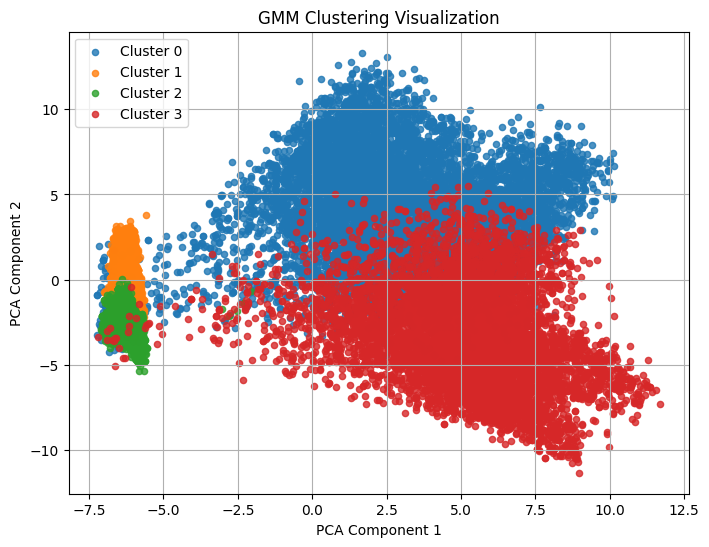

In [87]:
n_clusters = 4
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
gmm.fit(features_scaled)
clusters_gmm = gmm.predict(features_scaled)

# Анализ результатов
print("Кластеры:", set(clusters_gmm))
print("Размер каждого кластера:", {label: sum(clusters_gmm == label) for label in set(clusters_gmm)})

plt.figure(figsize=(8, 6))
for cluster in set(clusters_gmm):
    mask = clusters_gmm == cluster
    plt.scatter(features_2d[mask, 0], features_2d[mask, 1], label=f'Cluster {cluster}', s=20, alpha=0.8)

plt.title("GMM Clustering Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid()
plt.show()

## Сравнение результатов моделей

In [89]:
def evaluate_clustering(data, labels, method_name):
    silhouette = silhouette_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    calinski_harabasz = calinski_harabasz_score(data, labels)

    print(f"--- {method_name} ---")
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f}")
    print()

In [90]:
evaluate_clustering(features_scaled, clusters_kmeans, "KMeans")

--- KMeans ---
Silhouette Score: 0.071
Davies-Bouldin Index: 2.702
Calinski-Harabasz Index: 3342.961



In [104]:
evaluate_clustering(features_scaled, clusters_HDBSCAN, "HDBSCAN")

--- HDBSCAN ---
Silhouette Score: -0.219
Davies-Bouldin Index: 1.264
Calinski-Harabasz Index: 193.089



In [92]:
evaluate_clustering(features_scaled, clusters_gmm, "GMM")

--- GMM ---
Silhouette Score: 0.065
Davies-Bouldin Index: 2.780
Calinski-Harabasz Index: 3057.570



KMeans подходит для задач с примерно равными и компактными кластерами. Однако из-за слабой четкости кластеров его результаты не идеальны.

In [100]:
for cluster in set(clusters_kmeans):
    print(f"Cluster {cluster}:")
    print(features[['Salary_coded', 'Experience_coded']][clusters_kmeans == cluster].mean())

Cluster 0:
Salary_coded        61921.992015
Experience_coded        1.226575
dtype: float64
Cluster 1:
Salary_coded        61418.493081
Experience_coded        1.215975
dtype: float64
Cluster 2:
Salary_coded        44917.116198
Experience_coded        0.490531
dtype: float64
Cluster 3:
Salary_coded        52800.503541
Experience_coded        0.719904
dtype: float64


In [94]:
from collections import Counter

for cluster_id in set(clusters_kmeans):
    cluster_keywords = vacancies[clusters_kmeans == cluster_id]['Keywords'].sum()  # Все слова в кластере
    word_counts = Counter(cluster_keywords)
    most_common = word_counts.most_common(10)  # Топ-10 слов
    print(f"Cluster {cluster_id}: {most_common}")


Cluster 0: [('работа', 6458), ('обязанность', 2459), ('компания', 1887), ('опыт', 1731), ('знание', 1333), ('контроль', 951), ('требование', 899), ('документация', 878), ('подготовка', 846), ('организация', 844)]
Cluster 1: [('работа', 4631), ('обязанность', 1829), ('организация', 1342), ('контроль', 1305), ('опыт', 1138), ('компания', 1134), ('оформление', 1064), ('товар', 857), ('день', 779), ('знание', 775)]
Cluster 2: [('работа', 3603), ('обязанность', 2431), ('требование', 945), ('компания', 940), ('территория', 730), ('мы', 626), ('условие', 588), ('в', 540), ('требоваться', 534), ('уборка', 527)]
Cluster 3: [('работа', 5680), ('обязанность', 2737), ('компания', 1951), ('мы', 1208), ('продажа', 1159), ('опыт', 1055), ('наш', 975), ('клиент', 933), ('гость', 912), ('в', 793)]


In [96]:
for cluster_id in set(clusters_kmeans):
    cluster_keywords = vacancies[clusters_kmeans == cluster_id]['Skills_Tokenized'].sum()  # Все слова в кластере
    word_counts = Counter(cluster_keywords)
    most_common = word_counts.most_common(10)  # Топ-10 слов
    print(f"Cluster {cluster_id}: {most_common}")

Cluster 0: [('Пользователь ПК', 1309), ('Деловая переписка', 674), ('Работа в условиях многозадачности', 600), ('Работа в команде', 590), ('AutoCAD', 572), ('Работа с большим объемом информации', 501), ('Договорная работа', 498), ('1С Предприятие 8', 459), ('Складской Учет', 450), ('Охрана труда и техника безопасности', 439)]
Cluster 1: [('', 5504), ('Коммуникабельность', 9), ('Shell Scripting', 6), ('Ответственность', 5), ('ответственность', 5), ('Gerrit', 5), ('Tarantool', 5), ('Multithread Programming', 5), ('Bitbucket', 5), ('PostgreSQL', 5)]
Cluster 2: [('', 5068), ('Ответственность', 21), ('Работа в команде', 17), ('уборка территории', 15), ('Ответственность и пунктуальность', 15), ('Коммуникабельность', 14), ('Добросовестное выполнение поставленных задач', 11), ('Охрана объекта', 8), ('Умение работать в команде', 8), ('грузчик', 7)]
Cluster 3: [('Работа в команде', 3129), ('Грамотная речь', 2912), ('Пользователь ПК', 1738), ('Умение работать в команде', 988), ('Деловое общение',

***Заработная плата и опыт:***
+ Cluster 0 и Cluster 1: Схожие значения по заработной плате (\~61,000) и опыту (\~1.2). Эти группы могут представлять вакансии среднего уровня для специалистов с небольшим опытом.
+ Cluster 2: Самая низкая заработная плата (\~44,000) и минимальный опыт (\~0.5). Это может указывать на вакансии начального уровня.
+ Cluster 3: Средний уровень зарплаты (\~52,800) и опыт (\~0.7), что может отражать позиции с начальным или средним уровнем требований.\
    ***Ключевые слова:***
+ Cluster 0: Сосредоточен на управленческих и организационных задачах, таких как "контроль", "подготовка", "документация".
+ Cluster 1: Ближе к рутинным операциям, включая "товар", "оформление", "организация".
+ Cluster 2: Отражает вакансии с низкой квалификацией ("уборка", "территория", "требоваться").
+ Cluster 3: Смешанные позиции с фокусом на "продажи", "гости", "клиенты".\
    ***Навыки:***
+ Cluster 0: Высокая квалификация (например, "AutoCAD", "1С Предприятие 8").
+ Cluster 1 и Cluster 2: Большое количество пропусков или дублирующихся значений, что может указывать на низкоквалифицированные роли.
+ Cluster 3: Навыки, связанные с коммуникацией и продажами ("Грамотная речь", "Активные продажи").